## Hepatitis C Prediction Dataset
Context
The data set contains laboratory values of blood donors and Hepatitis C patients and demographic values like age. The data was obtained from UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/HCV+data

Content
All attributes except Category and Sex are numerical.
Attributes 1 to 4 refer to the data of the patient:
1) X (Patient ID/No.)
2) Category (diagnosis) (values: '0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis')
3) Age (in years)
4) Sex (f,m)
Attributes 5 to 14 refer to laboratory data:
5) ALB
6) ALP
7) ALT
8) AST
9) BIL
10) CHE
11) CHOL
12) CREA
13) GGT
14) PROT

The target attribute for classification is Category (2): blood donors vs. Hepatitis C patients (including its progress ('just' Hepatitis C, Fibrosis, Cirrhosis).

In [475]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
#from catboost import CatBoostClassifier, FeaturesData, Pool

In [476]:
df = pd.read_csv(r'D:\ML\anaconda3\envs\Projects_DS\Projects\Hepatit\HepatitisCdata.csv', index_col=0)

In [477]:
df.groupby('Category').count()

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
Category,,,,,,,,,,,,
0=Blood Donor,533,533,533,533,533,533,533,533,526,533,533,533
0s=suspect Blood Donor,7,7,7,7,7,7,7,7,7,7,7,7
1=Hepatitis,24,24,24,21,23,24,24,24,24,24,24,24
2=Fibrosis,21,21,21,12,21,21,21,21,20,21,21,21
3=Cirrhosis,30,30,29,24,30,30,30,30,28,30,30,29


In [478]:
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)

ind_1 = df.query('Category != "0=Blood Donor" and Category != "0s=suspect Blood Donor"').index
ind_0 = df.query('Category == "0=Blood Donor" or Category == "0s=suspect Blood Donor" ').index 
df['target'] = 0
df['target'].loc[ind_1] = 1
df.drop(columns=['Category'], inplace=True)

C:\Users\chekl\AppData\Local\Temp\ipykernel_21832\527775016.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'].loc[ind_1] = 1


In [479]:
is_na = df.isna().sum()
cols_wth_nan = is_na[is_na != 0].index
print(f'Признаки, содержащие Nan: {cols_wth_nan}')

Признаки, содержащие Nan: Index(['ALB', 'ALP', 'ALT', 'CHOL', 'PROT'], dtype='object')


In [480]:
# Заменяем Nan средним значением
for col in cols_wth_nan:
    df[col].fillna(df[col].mean(), inplace=True)

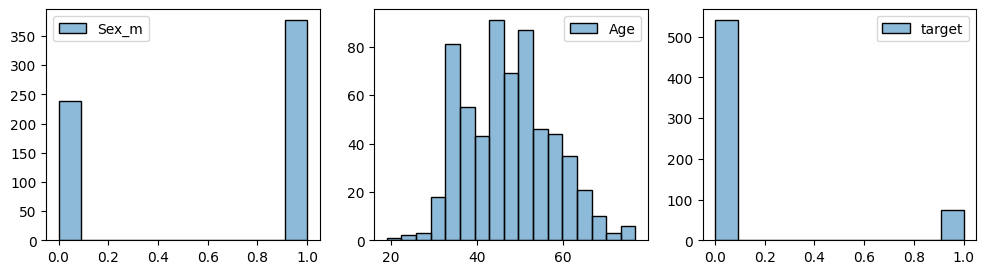

In [439]:
plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
sns.histplot(df[['Sex_m']])
plt.ylabel('')
plt.subplot(1,3,2)
sns.histplot(df[['Age']])
plt.ylabel('')
plt.subplot(1,3,3)
sns.histplot(df[['target']]) 
plt.ylabel('')
plt.show()

 * Наблюдается дисбаланс классов

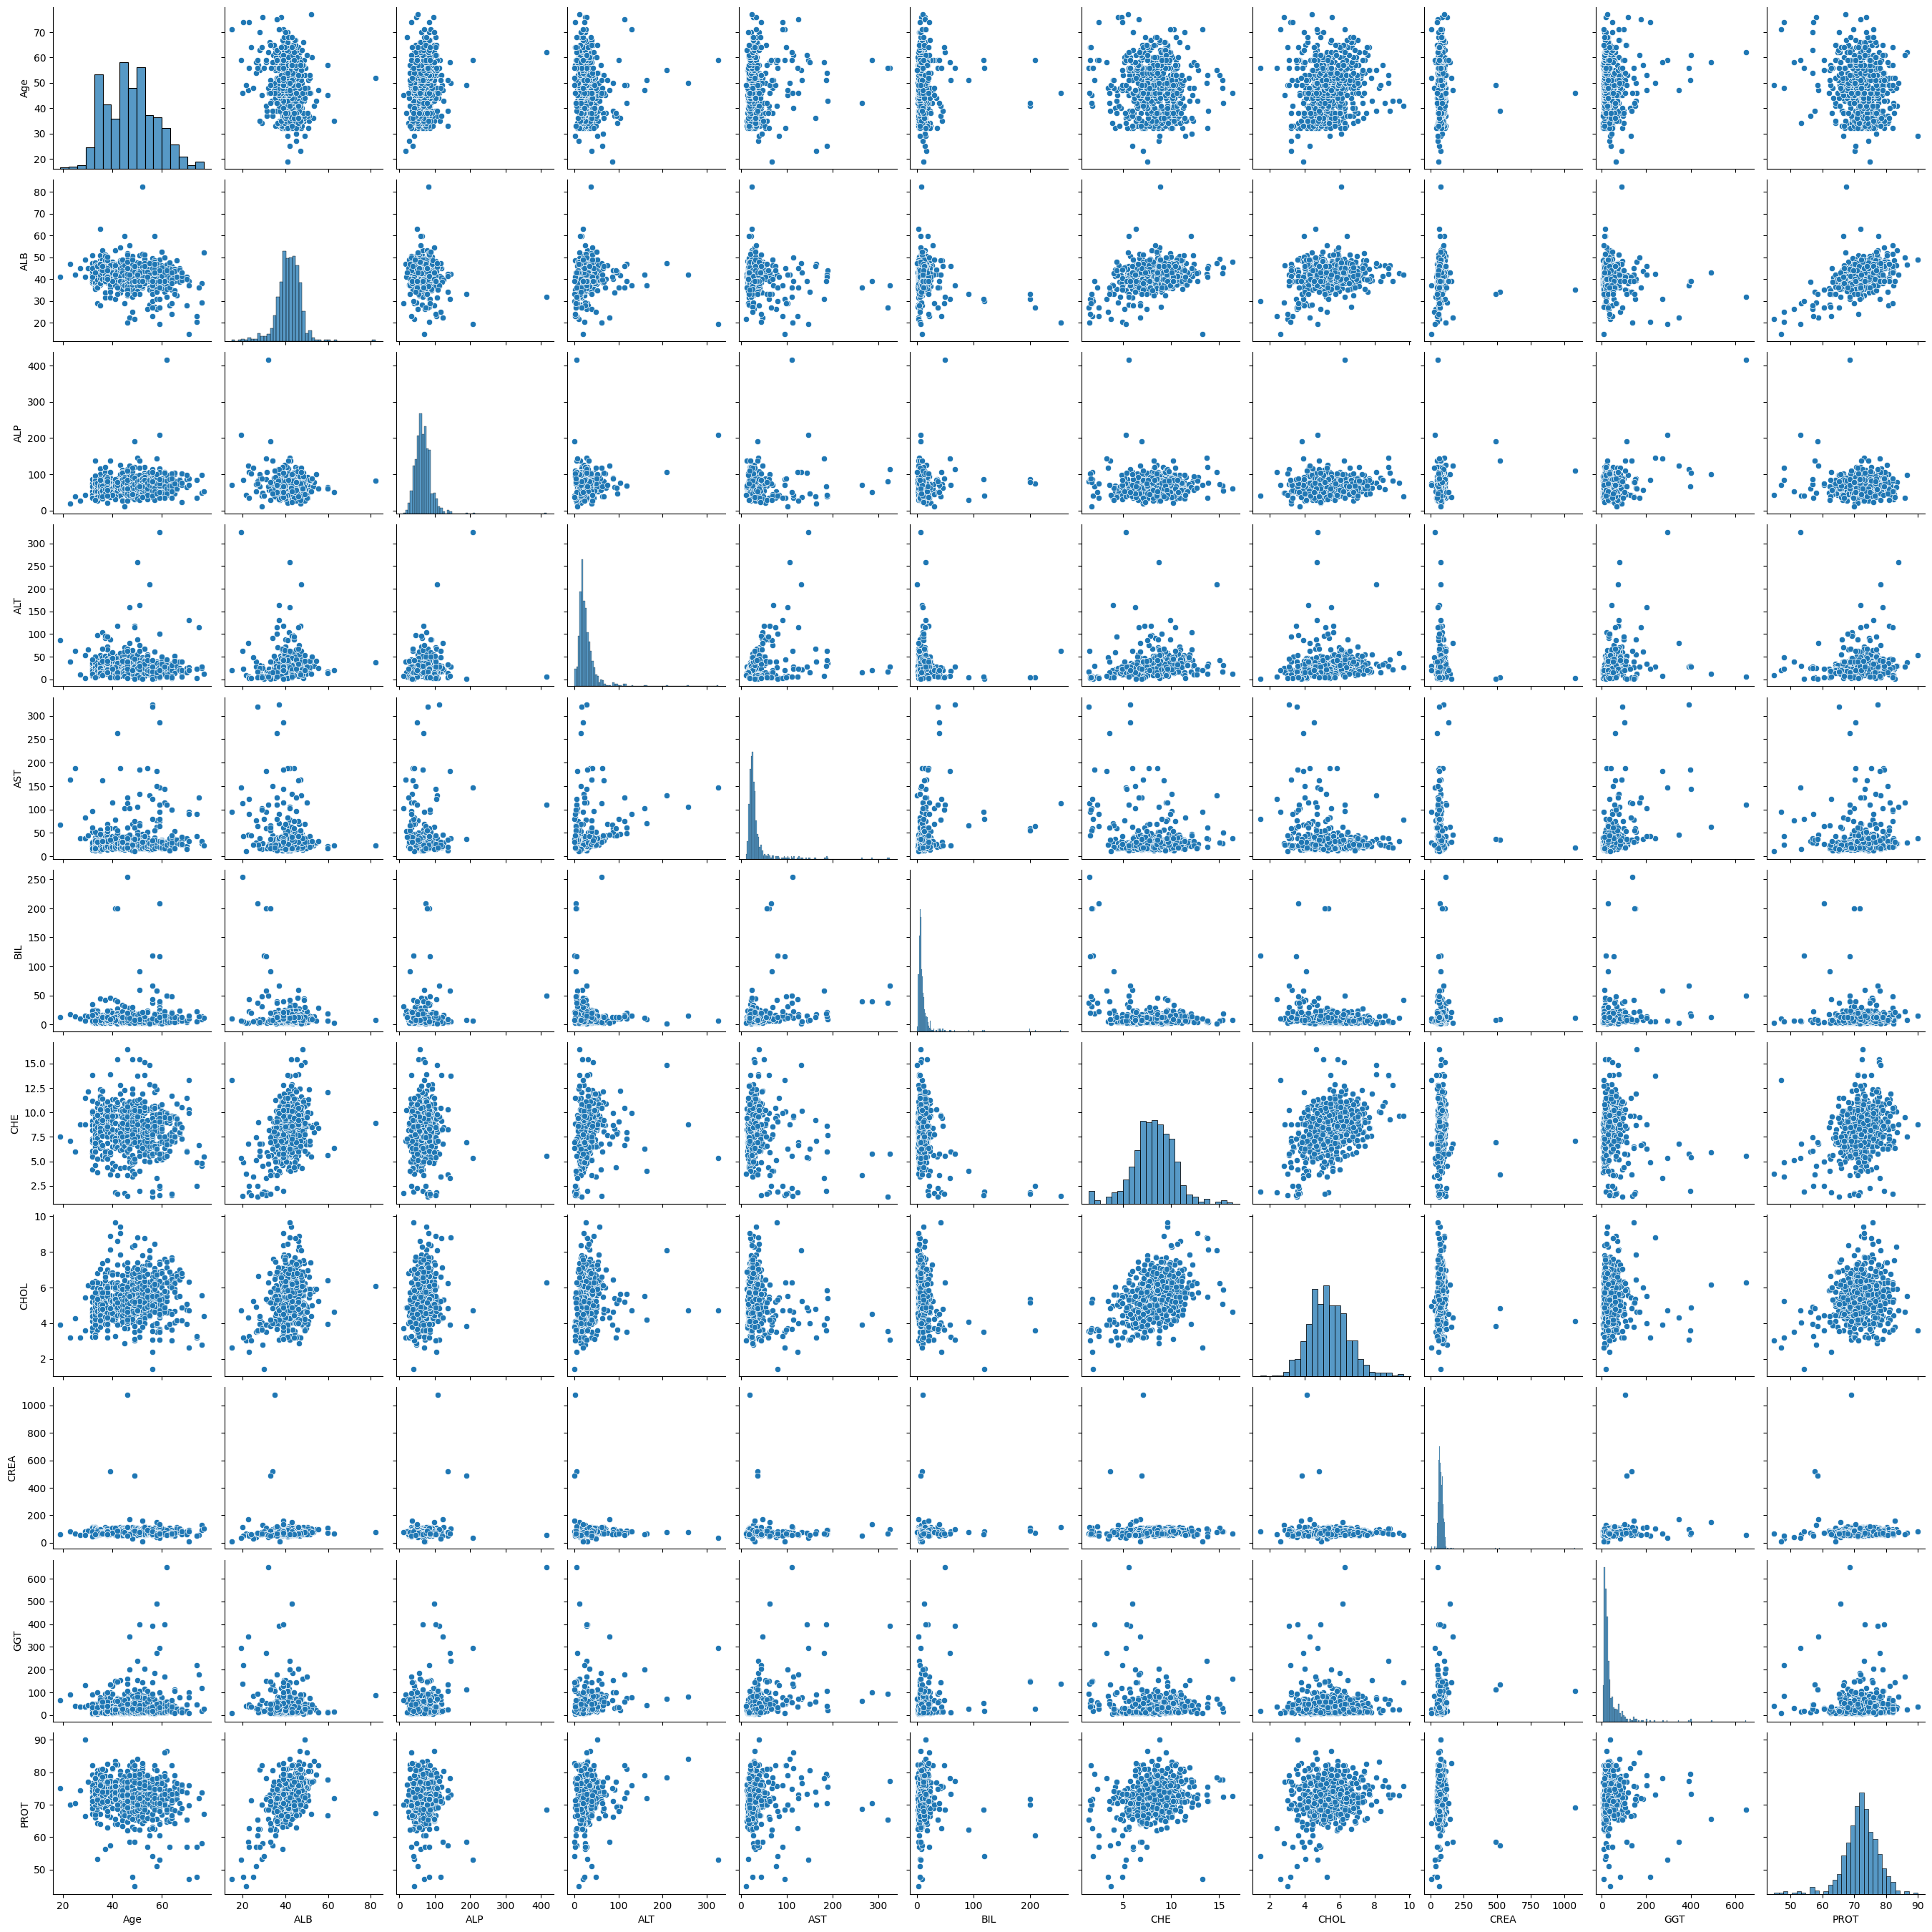

In [99]:
sns.pairplot(df[["Age", "ALB", 'ALP', 'ALT', "AST", "BIL", "CHE", "CHOL", "CREA", "GGT", "PROT"]])

In [440]:
def p_values(df):
    cols = pd.DataFrame(columns=df.columns)
    p = cols.transpose().join(cols, how='outer')
    p_corr = p.copy()
    for r_i, r in enumerate(df.columns):
        for c_i in range(r_i + 1, len(df.columns)):
            c = df.columns[c_i]
            p_corr[r][c], p[r][c] = pearsonr(df[r], df[c])
            p_corr[c][r] = p[r][c] #p_corr[r][c]
            #p[c][r] = p[r][c]

        p_corr[r][r] = 1
        p[r][r] = 0
    return p_corr, p

p_corr, p_val = p_values(df)

In [441]:
feature_non_corr = p_corr.target[p_corr.target > 0.05].index.to_list()
feature_wth_corr = p_corr.target[p_corr.target <= 0.05].index.to_list()

print(f'Верхняя диагональ - p-value, нижняя - коэффициент корреляции')
p_corr

Верхняя диагональ - p-value, нижняя - коэффициент корреляции


,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Sex_m,target
Age,1,0.000001,0.000027,0.881629,0.027899,0.421198,0.06273,0.002069,0.581034,0.000138,0.00013,0.543502,0.349596
ALB,-0.197005,1,0.000554,0.968289,0.000001,0.0,0.0,0.0,0.968943,0.000107,0.0,0.000279,0.000007
ALP,0.168473,-0.138858,1,0.000017,0.123339,0.228785,0.414372,0.002457,0.000197,0.0,0.184078,0.628514,0.128534
ALT,-0.006017,0.001606,0.172461,1,0.0,0.340903,0.000255,0.091902,0.286737,0.0,0.01924,0.000056,0.027793
AST,0.088666,-0.193397,0.062202,0.273325,1,0.0,0.0,0.0,0.596551,0.0,0.323358,0.00114,0.0
BIL,0.032492,-0.22165,0.0486,-0.038468,0.312231,1,0.0,0.0001,0.439563,0.0,0.306411,0.005779,0.0
CHE,-0.075093,0.375848,0.032971,0.146953,-0.208536,-0.333172,1,0.0,0.782449,0.006158,0.0,0.000025,0.0
CHOL,0.123978,0.204803,0.121914,0.068023,-0.207507,-0.156261,0.420163,1,0.237858,0.865806,0.0,0.459425,0.0
CREA,-0.022296,-0.001573,0.149554,-0.043025,-0.021387,0.031224,-0.011157,-0.047667,1,0.002649,0.432708,0.00007,0.000672
GGT,0.153087,-0.155555,0.442262,0.248086,0.491263,0.217024,-0.110345,-0.006828,0.121003,1,0.771475,0.000922,0.0


In [481]:
print(f'Признаки со статистически значимой корреляцией:\n{feature_wth_corr}\n')
print(f'Признаки, коррелирующие с целевой перемнной более, чем на 15%')
feature_corr = p_corr.loc['target'][feature_wth_corr][abs(p_corr.loc['target'][feature_wth_corr]) > 0.15]
print(feature_corr)

Признаки со статистически значимой корреляцией:
['ALB', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']

Признаки, коррелирующие с целевой перемнной более, чем на 15%
ALB    -0.179859
AST     0.621724
BIL     0.398451
CHE    -0.230785
CHOL   -0.265474
GGT      0.43768
Name: target, dtype: object


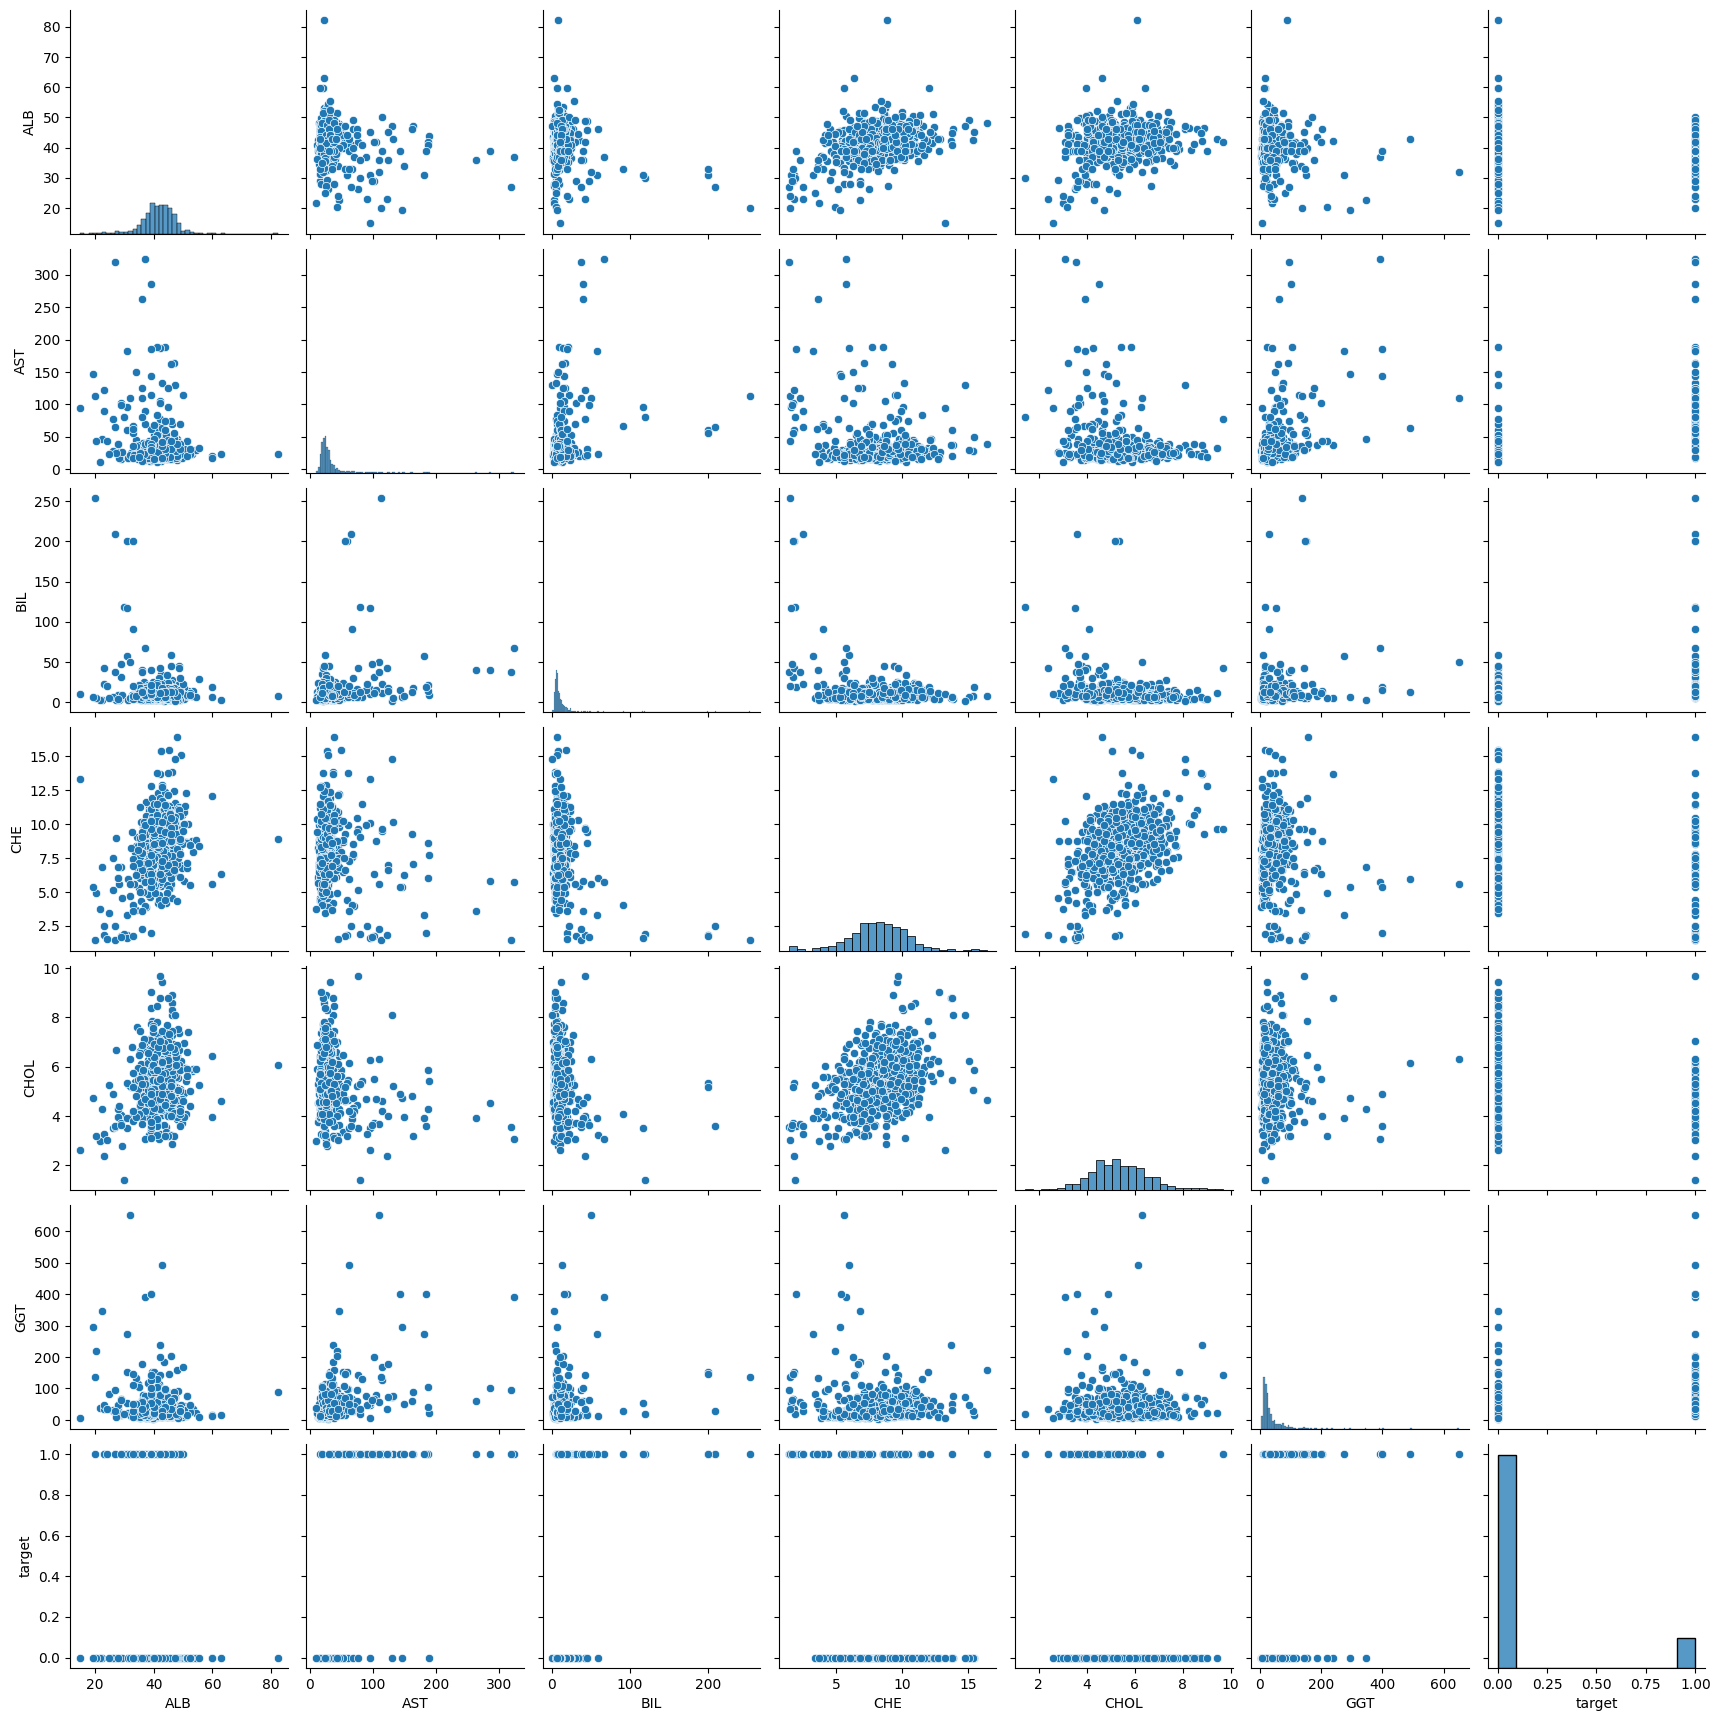

In [198]:
ind = feature_corr.index.to_list()
ind.append('target')
sns.pairplot(df[ind])
plt.show()

In [482]:
x = df[df.columns[:-1]]
y = df[df.columns[-1]]

In [483]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                   test_size = 0.3,
                                                   stratify = y,
                                                   random_state = 42)

In [484]:
from sklearn.utils import resample
from sklearn.model_selection import learning_curve

## Upsampling дисбаланса классов

In [485]:
n_samples = x_train[y_train == 0].shape[0] - x_train[y_train == 1].shape[0]

x_upsmpl, y_upsmpl = resample(x_train[y_train == 1],
                             y_train[y_train == 1],
                             replace= True,
                             n_samples= n_samples,
                             random_state= 123)
print(f'Количество наблюдений с y_train=1, которые надо добавить: {n_samples}')

Количество наблюдений с y_train=1, которые надо добавить: 326


In [486]:
x_train = pd.concat([x_train, x_upsmpl], axis=0)
y_train = pd.concat([y_train, y_upsmpl], axis=0)

## Модели

### Стандартизатор

In [487]:
numerical = x_train.columns[:-1]
num_pipe = Pipeline([('scaler', StandardScaler())])

linear_preprocessor = ColumnTransformer(
    transformers=[('num', num_pipe, numerical)],
    remainder='passthrough'
)

In [508]:
def feature_importance(data, estimator_name='estimator'):
    feature_importance = pd.DataFrame(data=data, 
                                    index=x.columns.astype('str'), 
                                    columns=['importance'])
    feature_importance.sort_values(by='importance', ascending=False, inplace=True)

    sns.barplot(data=feature_importance,
               x = feature_importance.index,
               y = feature_importance['importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Признак')
    plt.ylabel('Важность признака')
    plt.title(f'Важность признаков по оценке {estimator_name}')
    plt.show()
    return feature_importance

In [489]:
def plot_confusion_matrix(y_test, y_pred, name_estimator):
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)

    disp.plot(colorbar=False)
    plt.title(f'Матрица неточностей {name_estimator}')
    plt.show()

    print(f'Точность: {precision_score(y_test, y_pred):.3f}')
    print(f'\nПолнота: {recall_score(y_test, y_pred):.3f}')
    print(f'\nF1 мера: {f1_score(y_test, y_pred):.3f}')

### LogReg

In [490]:
lr = make_pipeline(linear_preprocessor,
                  LogisticRegression(max_iter=1000))

best_score = np.mean(cross_val_score(lr, x_train, y_train, scoring='accuracy', cv=4, n_jobs=-1))
print(f'Качество модели по кросс-валидации: {best_score:.3f}')

Качество модели по кросс-валидации: 0.962


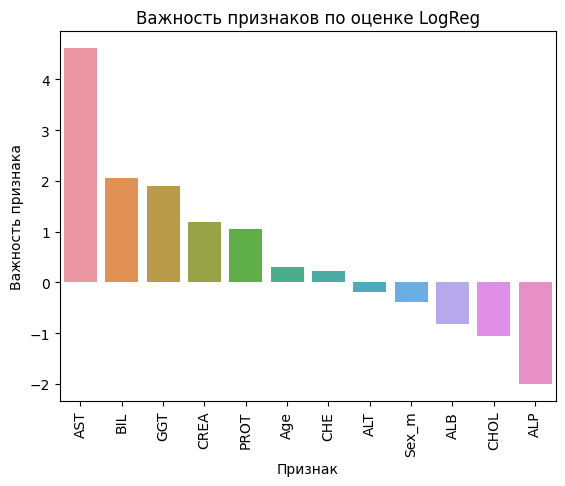

In [509]:
lr.fit(x_train, y_train)
data_lr = lr[1].coef_[0]
feature_importance_logreg = feature_importance(data_lr, estimator_name= 'LogReg' )

In [492]:
args = np.argsort(abs(feature_corr.values))
args
feature_corr[args]

ALB    -0.179859
CHE    -0.230785
CHOL   -0.265474
BIL     0.398451
GGT      0.43768
AST     0.621724
Name: target, dtype: object

## Кривая обучения

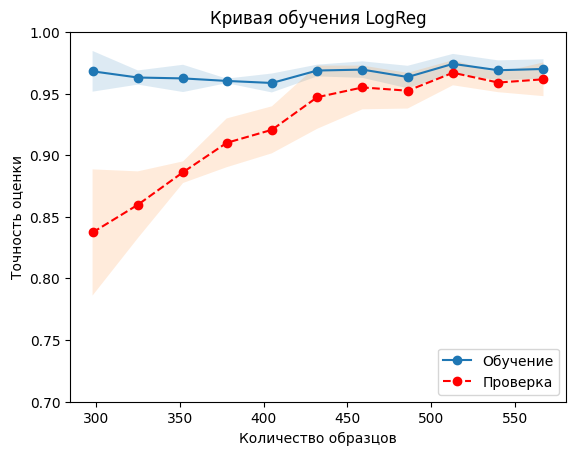

In [453]:
tr_size, tr_scor, tst_scor = learning_curve(estimator=lr, 
                                           X = x_train,
                                           y = y_train,
                                           train_sizes=np.linspace(0.1, 1, 20),
                                           cv = 4)

plt.plot(tr_size, np.mean(tr_scor, axis=1), marker='o', label='Обучение')
plt.fill_between(tr_size,
                 np.mean(tr_scor, axis=1) - np.std(tr_scor, axis=1),
                 np.mean(tr_scor, axis=1) + np.std(tr_scor, axis=1),
                 alpha=0.15)

plt.plot(tr_size, np.mean(tst_scor, axis=1), marker='o', linestyle='--', color='r', label='Проверка')
plt.fill_between(tr_size,
                 np.mean(tst_scor, axis=1) - np.std(tst_scor, axis=1),
                 np.mean(tst_scor, axis=1) + np.std(tst_scor, axis=1),
                 alpha=0.15)

plt.ylim(0.7, 1)
plt.xlabel('Количество образцов')
plt.ylabel('Точность оценки')
plt.title('Кривая обучения LogReg')
plt.legend(loc='lower right')

plt.show()

* По кривой обучения видим, что для тернировки надо от 450 образцов.

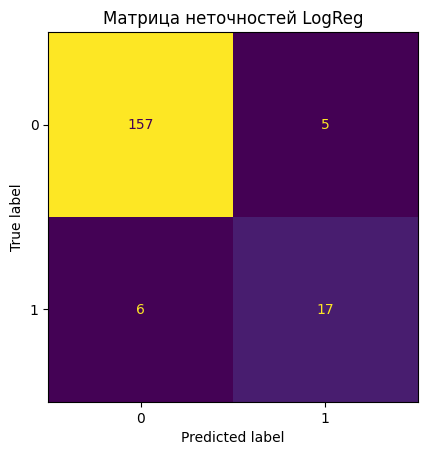

Точность: 0.773

Полнота: 0.739

F1 мера: 0.756


In [493]:
y_pred = lr.predict(x_test)
plot_confusion_matrix(y_test, y_pred, 'LogReg')

* Модель хорошо распознает здоровых и больных пациентов.

In [494]:
param_grid = [{'logisticregression__C': [0.1, 1.5, 3, 10, 20],
              'logisticregression__penalty': ['l1'],
              'logisticregression__solver': ['liblinear', 'saga']},
             {'logisticregression__C': [0.01, 0.1, 1.5, 3, 10],
              'logisticregression__penalty': ['l2'],
              'logisticregression__solver': ['saga', 'lbfgs']}]

gs = GridSearchCV(estimator=lr,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=4,
                 refit=True,
                 n_jobs=-1)

gs = gs.fit(x_train, y_train)
print(f'{gs.best_score_:.3f}')
print(gs.best_params_)

0.971
{'logisticregression__C': 10, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


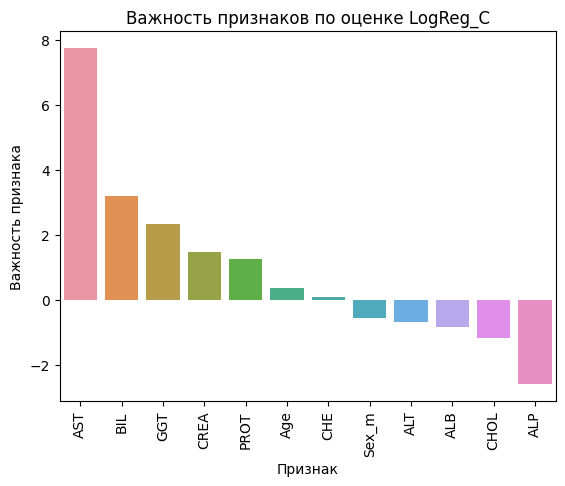

In [510]:
gs.best_estimator_.fit(x_train, y_train)
data_lr_c= gs.best_estimator_.steps[1][1].coef_[0]

#data_lr_c
feature_importance_logreg_c = feature_importance(data = data_lr_c, estimator_name='LogReg_C')
 

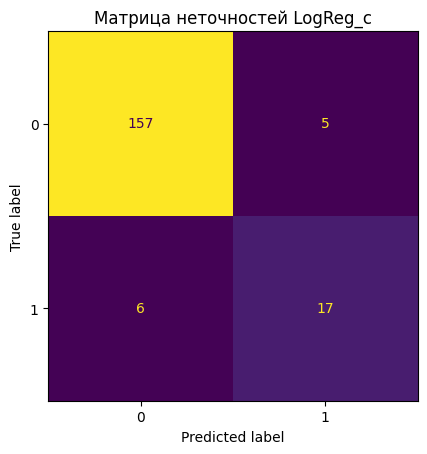

Точность: 0.773

Полнота: 0.739

F1 мера: 0.756


In [497]:
y_pred = gs.best_estimator_.predict(x_test)
plot_confusion_matrix(y_test, y_pred, 'LogReg_c')

## Decision Tree

In [498]:
tree = make_pipeline(StandardScaler(),
                    DecisionTreeClassifier(random_state=42))

param_grid = {'decisiontreeclassifier__max_depth': [5, 6, 7, 8, 9, 10],
              'decisiontreeclassifier__min_samples_split': [2, 4, 6, 8],
              'decisiontreeclassifier__min_samples_leaf': [1, 2, 4, 6, 8, 10]}

gs_tree = GridSearchCV(tree, param_grid=param_grid, cv=4, scoring='accuracy', n_jobs=-1, refit=True)
gs_tree.fit(x_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [5, 6, 7, 8, 9,
                                                               10],
                         'decisiontreeclassifier__min_samples_leaf': [1, 2, 4,
                                                                      6, 8,
                                                                      10],
                         'decisiontreeclassifier__min_samples_split': [2, 4, 6,
                                                                       8]},
             scoring='accuracy')

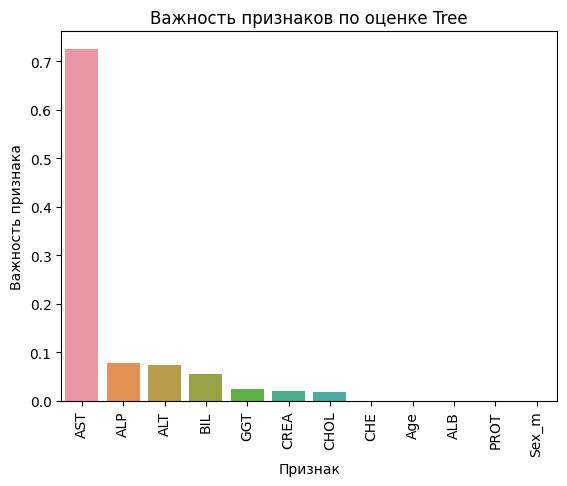

In [499]:
data = gs_tree.best_estimator_[1].feature_importances_
feature_importance_tree = feature_importance(data, estimator_name='Tree')

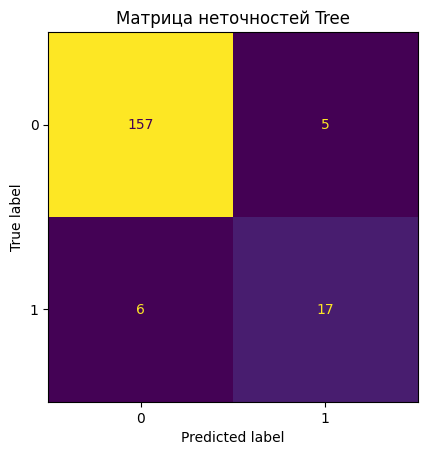

Точность: 0.773

Полнота: 0.739

F1 мера: 0.756


In [500]:
y_pred = gs.best_estimator_.predict(x_test)
plot_confusion_matrix(y_test, y_pred, 'Tree')

## GradientBoosting

In [501]:
boost = make_pipeline(StandardScaler(),
                       GradientBoostingClassifier(random_state=0))

param_grid = dict(gradientboostingclassifier__learning_rate=[0.1, 0.5, 1, 1.5, 3],
                 gradientboostingclassifier__n_estimators=[100, 50, 200])

gs_boost = GridSearchCV(boost, param_grid, scoring='accuracy', cv=4, refit=True)

gs_boost.fit(x_train, y_train)


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=0))]),
             param_grid={'gradientboostingclassifier__learning_rate': [0.1, 0.5,
                                                                       1, 1.5,
                                                                       3],
                         'gradientboostingclassifier__n_estimators': [100, 50,
                                                                      200]},
             scoring='accuracy')

In [502]:
gs_boost.best_params_

{'gradientboostingclassifier__learning_rate': 0.5,
 'gradientboostingclassifier__n_estimators': 100}

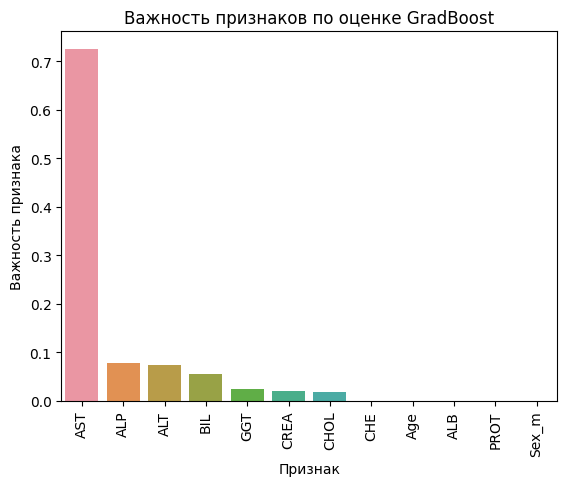

In [503]:
boost = gs_boost.best_estimator_[1].feature_importances_
feature_importance_boost = feature_importance(data, estimator_name='GradBoost')

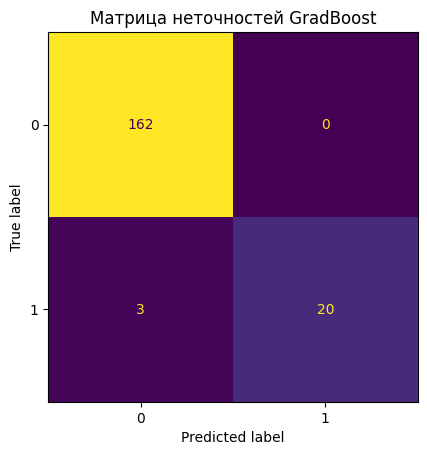

Точность: 1.000

Полнота: 0.870

F1 мера: 0.930


In [504]:
y_pred = gs_boost.best_estimator_.predict(x_test)
plot_confusion_matrix(y_test, y_pred, 'GradBoost')

## Проверка модели бустинга на сбалансированной тестовой выборке
Поскольку 1 класса в тесте много меньше, чем 0 класса, то "хорошая" матрица неточностей может быть обусловлена дисбалансом. Проверим как будет работать модель на сбалансированной тестовой выборке. Для этого уменьшим количество наблюдений 0 класса в тестовых данных.

In [505]:
n_samples = x_test[y_test == 1].shape[0]

x_upsmpl, y_upsmpl = resample(x_test[y_test == 0],
                             y_test[y_test == 0],
                             replace= True,
                             n_samples= n_samples,
                             random_state= 123)
print(f'Количество наблюдений с y_test=0, которые надо оставить: {n_samples}')



Количество наблюдений с y_test=0, которые надо оставить: 23


In [506]:
x_tst_upsmpl = pd.concat([x_test[y_test==1], x_upsmpl], axis=0)
y_tst_upsmpl = pd.concat([y_test[y_test==1], y_upsmpl], axis=0)

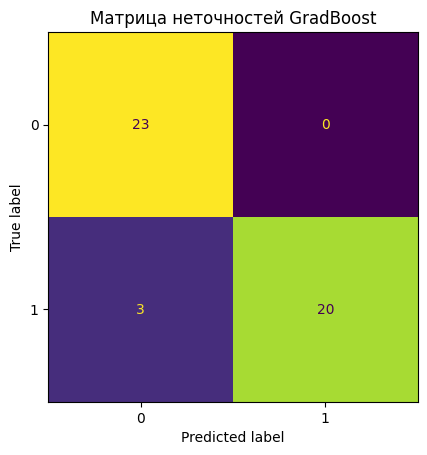

Точность: 1.000

Полнота: 0.870

F1 мера: 0.930


In [507]:
y_pred_upsmpl = gs_boost.best_estimator_.predict(x_tst_upsmpl)
plot_confusion_matrix(y_tst_upsmpl, y_pred_upsmpl, 'GradBoost')

## Заключение
* Наилучшую точность классификации дала модель бустинга. 

* 13% ложноотрицательных, 0% ложноположительных - GradientBoosting

* 26% ложноотрицательных, 3% ложноположительных - LogReg, DecisionTree

* Предсказание бустингом на сбалансированной тествовой выборке осталось качественным.

* Статистическки значимые признаки с корреляцией >15% : 
ALB    -0.265474
AST    -0.230785
BIL    -0.179859
CHE     0.398451
CHOL     0.43768
GGT     0.621724

